In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
from scipy.stats import chi2

import sys
sys.path.insert(0, '/home/mehdi/github/LSSutils')
from lssutils.lab import histogram_cell

In [2]:
"""

    'star_density', 'ebv', 'loghi',
    'sky_g', 'sky_r', 'sky_i', 'sky_z',
    'depth_g_minus_ebv','depth_r_minus_ebv', 
    'depth_i_minus_ebv', 'depth_z_minus_ebv', 
    'psf_g', 'psf_r', 'psf_i', 'psf_z',
     'run', 'airmass'


"""
from scipy.special import gamma

def chi2_pdf(x, k):
    """ Chi2 pdf 
    """
    k2 = k / 2.
    n_ = np.power(x, k2-1.)
    d_ = np.power(2., k2)*gamma(k2)
    return np.exp(-0.5*x)*n_/d_    

def chi2_fn(y, invcov):
    return np.dot(y, np.dot(invcov, y))    

def read_cl(fn, ix=[i for i in range(17)], colmax=None):
    
    cl = np.load(fn, allow_pickle=True).item()
    cl_cross = []
    cl_ss = []
    
    for i in ix:    
        l_, cl_sg_ = histogram_cell(cl['cl_sg'][i]['cl'])
        l_, cl_ss_ = histogram_cell(cl['cl_ss'][i]['cl'])
        
        cl_ss.append(cl_ss_)
        cl_cross.append(cl_sg_[:colmax]**2/cl_ss_[:colmax])    
    
    return l_[:colmax], np.array(cl_cross), cl_ss


def read_clmocks(fn, cl_ss, ix=[i for i in range(17)], colmax=None):
    
    cl = np.load(fn, allow_pickle=True).item()
    cl_cross = []
    
    
    for i in ix:    
        l_, cl_sg_ = histogram_cell(cl['cl_sg'][i]['cl'])
        cl_ss_ = cl_ss[i]
        
        cl_cross.append(cl_sg_[:colmax]**2/cl_ss_[:colmax])    
    
    return l_[:colmax], np.array(cl_cross)

In [3]:
def run(cap='NGC'):
    print(cap)
    
    # data
    p = '/home/mehdi/data/eboss/data/v7_2/3.0/measurements/cl/'
    cl = {}
    cl['noweight'] = read_cl(f'{p}cl_{cap}_noweight_mainhighz_512_v7_2_main_512.npy', colmax=4)
    cl['systot'] = read_cl(f'{p}cl_{cap}_knownsystot_mainhighz_512_v7_2_main_512.npy', colmax=4)
    cl['nn'] = read_cl(f'{p}cl_{cap}_known_mainhighz_512_v7_2_main_512.npy', colmax=4)    
    
    # mocks
    p = '/home/mehdi/data/eboss/mocks/1.0/measurements/cl/'
    mocks = glob(f'{p}cl_{cap}_knownsystot_mainhighz_512_v7_0_*')
    print(len(mocks))
    
    clmocks = []
    for mock_i in mocks:
        clmock_ = read_clmocks(mock_i, cl['nn'][2], colmax=4)[1]
        clmocks.append(clmock_.flatten())
        
    err_tot = np.array(clmocks)
    nmocks, nbins = err_tot.shape
    hartlapf = (nmocks-1. - 1.) / (nmocks-1. - nbins - 2.)
    indices = [i for i in range(nmocks)]

    # chi2 of mocks
    chi2s = []
    for i in range(nmocks):
        indices_ = indices.copy()    
        indices_.pop(i)

        nbar_ = err_tot[i, :]
        err_ = err_tot[indices_, :]    
        covmax_ = np.cov(err_, rowvar=False)
        invcov_ = np.linalg.inv(covmax_*hartlapf)

        chi2_ = chi2_fn(nbar_, invcov_)
        chi2s.append(chi2_)        
        
    # chi2 of data    
    chi2d = {}
    for i, (name, cl_) in enumerate(cl.items()):
        chi2d[name] = chi2_fn(cl_[1].flatten(), invcov_)
        
    plt.hist(chi2s, bins=30, alpha=0.2, label='EZmocks')
    plt.yscale('log')
    plt.xlabel(r'$\chi^{2}_{\rm tot}$')

    ls = ['-', '--']
    i = 0
    for n,v in chi2d.items():
        if n == 'noweight':
            continue
        plt.axvline(v, ls=ls[i], label=n)
        i += 1
    plt.legend()

NGC
1000


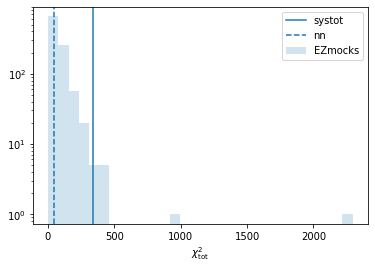

In [4]:
run('NGC')

SGC
999


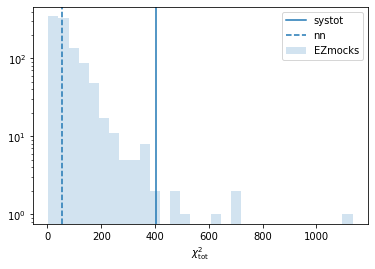

In [5]:
run('SGC')

In [6]:
p = '/home/mehdi/data/eboss/data/v7_2/3.0/measurements/cl/'
cl = {}

cl['noweight'] = read_cl(f'{p}cl_NGC_noweight_mainhighz_512_v7_2_main_512.npy', colmax=4)
cl['systot'] = read_cl(f'{p}cl_NGC_knownsystot_mainhighz_512_v7_2_main_512.npy', colmax=4)
cl['nn'] = read_cl(f'{p}cl_NGC_known_mainhighz_512_v7_2_main_512.npy', colmax=4)

In [7]:
cl['nn']

(array([ 1.62983096,  3.68286698,  8.3220343 , 18.80498406]),
 array([[7.97197877e-08, 3.59407476e-08, 1.36562659e-09, 1.48917361e-08],
        [6.62837333e-07, 1.84635711e-09, 1.07525733e-09, 4.29297006e-08],
        [7.18498840e-07, 2.62959616e-10, 2.04517307e-10, 8.06576123e-08],
        [1.08440405e-06, 1.42889967e-07, 1.09255130e-09, 1.00853417e-07],
        [1.10052859e-06, 2.36032087e-07, 1.31640526e-07, 1.96241414e-08],
        [1.17153316e-06, 4.03098287e-07, 7.33706570e-07, 7.87584067e-09],
        [1.05588057e-06, 2.84049453e-07, 7.23247793e-07, 1.23629155e-10],
        [1.03708973e-06, 2.31197484e-07, 7.37751278e-08, 2.86720012e-09],
        [1.12053939e-06, 3.66029174e-07, 2.81760853e-07, 7.78429523e-12],
        [1.10865022e-06, 4.98774436e-07, 6.88464457e-07, 1.07608211e-08],
        [9.35718248e-07, 4.44117945e-07, 6.66727173e-07, 3.11214250e-08],
        [6.88228712e-07, 5.00964038e-07, 2.30827250e-07, 7.84623945e-08],
        [1.67407370e-07, 3.00686742e-07, 2.0330715

In [4]:
colnames = ['star_density', 'ebv', 'loghi',
    'sky_g', 'sky_r', 'sky_i', 'sky_z',
    'depth_g_minus_ebv','depth_r_minus_ebv', 
    'depth_i_minus_ebv', 'depth_z_minus_ebv', 
    'psf_g', 'psf_r', 'psf_i', 'psf_z',
     'run', 'airmass']

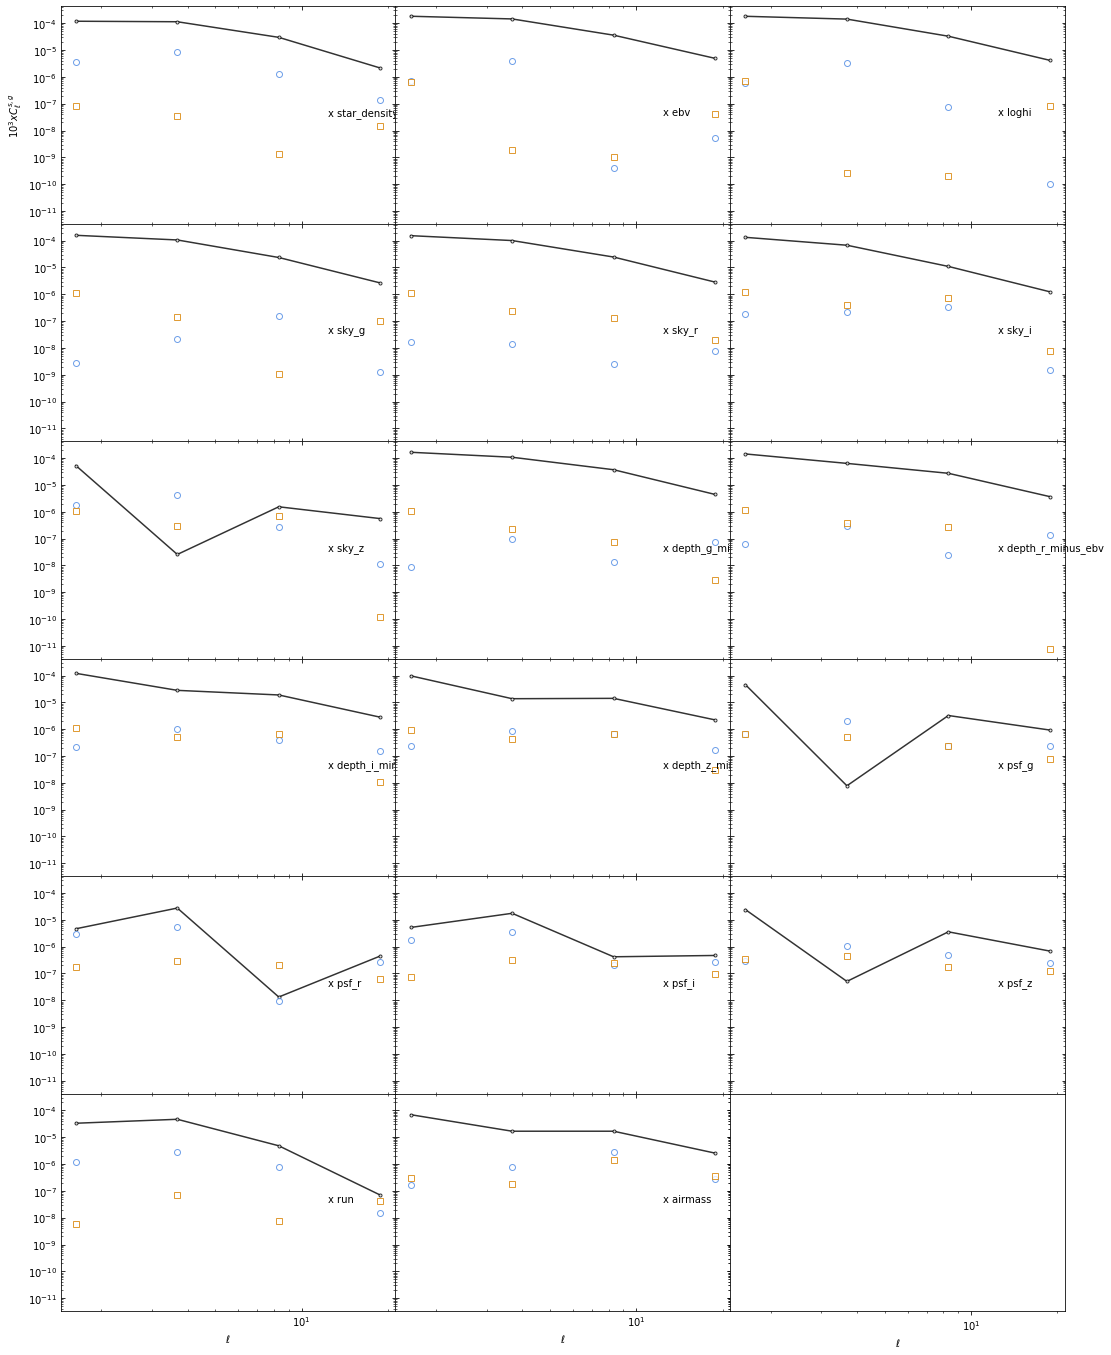

In [5]:
fig, ax = plt.subplots(ncols=3, nrows=6, figsize=(18, 24),
                       sharey=True, sharex=True)
ax = ax.flatten()
fig.subplots_adjust(hspace=0.0, wspace=0.0)

markers = {'noweight':'.',
         'systot':'o',
         'nn':'s'}

colors = {'noweight':'#000000',
         'systot':'#4b88e3',
         'nn':'#d98404'}

labels = {'noweight':'20% Before treatment',
         'systot':'Standard treatment',
         'nn':'Neural Network treatment'} 

sf = 1.0e3
for i, (name, cl_) in enumerate(cl.items()):
    
    ls = '-' if name=='noweight' else 'none'
    
    for j in range(17):
        
        ax[j].plot(cl_[0], cl_[1][j], label=labels[name], 
                marker=markers[name], color=colors[name],
                mfc='w', alpha=0.8, ls=ls)
    
    #chi2v = chi2_fn(nbar[1], nbar[2])
    #ax.text(0.7, 0.92-i*0.06, r'$\chi^{2}/dof$ = %.2f/%d'%(chi2v,len(nbar[1])),
    #        color=colors[name], transform=ax.transAxes)
    
for i,axi in enumerate(ax[:-1]):
    axi.tick_params(direction='in', which='both', 
                    axis='both', right=True, top=True)   
    axi.text(0.8, 0.5, f'x {colnames[i]}', transform=axi.transAxes)
    
for axi in ax[-3:]:    
    axi.set(xlabel=r'$\ell$')
    
_ = ax[0].set(xscale='log', yscale='log', ylabel=r'$10^{3}x C_{\ell}^{s,g}$')
# ax.axhline(0, ls=':', color='grey')    
# ax.legend(title='NGC (0.8<z<2.2)', frameon=False)
# ax.set(xlabel='E(B-V)', ylabel=r'$\delta$')

# fig.savefig('cl_ngc_512.png', dpi=300, bbox_inches='tight')

In [15]:
mocks = glob('/home/mehdi/data/eboss/mocks/1.0/measurements/cl/cl_NGC_knownsystot_mainhighz_512_v7_0_*')
len(mocks)

1000

In [16]:
clmocks = []
for mock_i in mocks:
    clmock_ = read_clmocks(mock_i, cl['nn'][2], colmax=4)[1]
    clmocks.append(clmock_.flatten())
    print('.', end='')

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [20]:
err_tot = np.array(clmocks)

nmocks, nbins = err_tot.shape

hartlapf = (nmocks-1. - 1.) / (nmocks-1. - nbins - 2.)
indices = [i for i in range(nmocks)]

chi2s = []

for i in range(nmocks):
    indices_ = indices.copy()    
    indices_.pop(i)
    
    nbar_ = err_tot[i, :]
    
    err_ = err_tot[indices_, :]    
    covmax_ = np.cov(err_, rowvar=False)
    invcov_ = np.linalg.inv(covmax_*hartlapf)
    
    chi2_ = chi2_fn(nbar_, invcov_)
    
    chi2s.append(chi2_)    

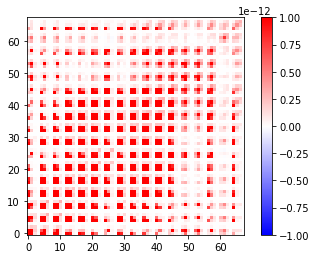

In [25]:
plt.imshow(covmax_, origin='lower', cmap=plt.cm.bwr, vmin=-1.0e-12, vmax=1.0e-12)
plt.colorbar()

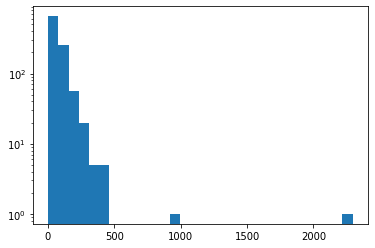

In [29]:
_ = plt.hist(chi2s, bins=30)
plt.yscale('log')

In [37]:
chi2d = {}
for i, (name, cl_) in enumerate(cl.items()):
    chi2d[name] = chi2_fn(cl_[1].flatten(), invcov_)
chi2d

{'noweight': 211619.65330254822,
 'systot': 340.08297730208733,
 'nn': 49.716003506932736}

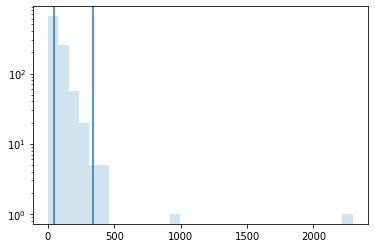

In [41]:
_ = plt.hist(chi2s, bins=30, alpha=0.2)
plt.yscale('log')

for n,v in chi2d.items():
    if n == 'noweight':
        continue
    plt.axvline(v)